# 문서 유사도 (Document Similarity)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import nltk
from nltk.stem import WordNetLemmatizer
import string

In [16]:
path = 'C:\\encore_skn11\\07_nlp\\01_text_analysis\\data\\OpinosisDataset1.0\\topics'
all_files = glob.glob(os.path.join(path, '*.data'))     # 파일 경로를 리스트로 읽어옴 # [파일1, 파일2, .., 파일n]

filename_list = []
opinions_list = []

for file_ in all_files:
    # 하나의 파일에 있는 의견을 하나의 df로 만듦
    df = pd.read_table(file_, header=None, index_col=None, encoding='latin1')
    # display(df)   # 각 corpus 담고 있는 데이터프레임

    # 파일명
    filename = file_.split('\\')[-1]        # 파일명.확장자
    filename = filename.split('.')[0]       # 파일명
    filename_list.append(filename)

    # 의견 내용
    opinions = df.to_string(index=False, header=False)
    opinions_list.append(opinions)

document_df = pd.DataFrame({
    'filename': filename_list,
    'opinions': opinions_list
}) 
# document_df

In [17]:
def lemmatize(text):
    '''
    소문자 변환, 특수문자 제거, 토큰화, 어근 분리
    '''

    # 소문자 변환 - why? 불용어와 맞춰주기 위해
    text = text.lower()

    # 특수문자 제거
    punc_rem_dict = dict((ord(ch), None) for ch in string.punctuation)      # ord: string to unicode
    text = text.translate(punc_rem_dict)

    # 토큰화
    tokens = nltk.word_tokenize(text)

    # 어근 분리
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token, pos='v') for token in tokens]       # lemmatizer: 어근 분리 -> pos='v' 동사형으로

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lemmatize,        # 어떤 토크나이저를 사용할건지 적기 -> 위에서 정의한 lemmatize 함수 사용
    stop_words='english',
    ngram_range=(1,2),
    max_df=0.85,
    min_df=0.05
)

opinions_vecs = tfidf_vectorizer.fit_transform(document_df['opinions'])    # 

c:\Users\Playdata\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Playdata\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=5000, random_state=0)
document_df['cluster'] = kmeans.fit_predict(opinions_vecs)
document_df.head()

,filename,opinions,cluster
0,accuracy_garmin_nuvi_255W_gps,...,2
1,bathroom_bestwestern_hotel_sfo,...,1
2,battery-life_amazon_kindle,...,0
3,battery-life_ipod_nano_8gb,...,2
4,battery-life_netbook_1005ha,...,2


In [ ]:
hotel_index = document_df[document_df['cluster'] == 1].index
print(hotel_index.shape)
print(hotel_index)

# 1번 군집에 해당하는 의견 가져오기
base_index=1
document_df.iloc[base_index]

(15,)
Index([1, 13, 14, 15, 20, 21, 24, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')


filename                       bathroom_bestwestern_hotel_sfo
opinions                                                  ...
cluster                                                     1
Name: 1, dtype: object

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

print(opinions_vecs[base_index].shape, opinions_vecs.shape)
opinions_sim = cosine_similarity(opinions_vecs[base_index], opinions_vecs)
opinions_sim

(1, 4072) (51, 4072)


array([[0.00748211, 1.        , 0.00929825, 0.0057907 , 0.00951122,
        0.01189862, 0.04207734, 0.05068772, 0.00883856, 0.00840561,
        0.01333684, 0.0118808 , 0.01204711, 0.04527121, 0.05728026,
        0.06248841, 0.00753869, 0.02152493, 0.01696471, 0.02047214,
        0.06173425, 0.06124276, 0.00748295, 0.00877269, 0.04074639,
        0.01315832, 0.0105536 , 0.0222888 , 0.11626805, 0.00537765,
        0.41683399, 0.36028138, 0.51119681, 0.00799792, 0.01306653,
        0.01888393, 0.02248538, 0.01884263, 0.11499329, 0.15210166,
        0.1506946 , 0.04685638, 0.00708347, 0.00407049, 0.0150326 ,
        0.09851446, 0.08026128, 0.00684375, 0.00568624, 0.00898582,
        0.0080185 ]])

In [25]:
opinions_sorted_idx = opinions_sim.argsort()[::-1]      # 내림차순 정렬 (유사도 높은 순)
opinions_sorted_idx = opinions_sorted_idx[:,1:]         # 자기자신 제외
opinions_sorted_idx = opinions_sorted_idx.reshape(-1)

result_df = document_df.iloc[opinions_sorted_idx][['filename','cluster']]
opinions_sim = opinions_sim.reshape(-1)
result_df['similarity'] = opinions_sim[opinions_sorted_idx]
result_df.head()

,filename,cluster,similarity
29,quality_toyota_camry_2007,3,0.005378
48,updates_garmin_nuvi_255W_gps,2,0.005686
3,battery-life_ipod_nano_8gb,2,0.005791
47,transmission_toyota_camry_2007,3,0.006844
42,sound_ipod_nano_8gb,2,0.007083


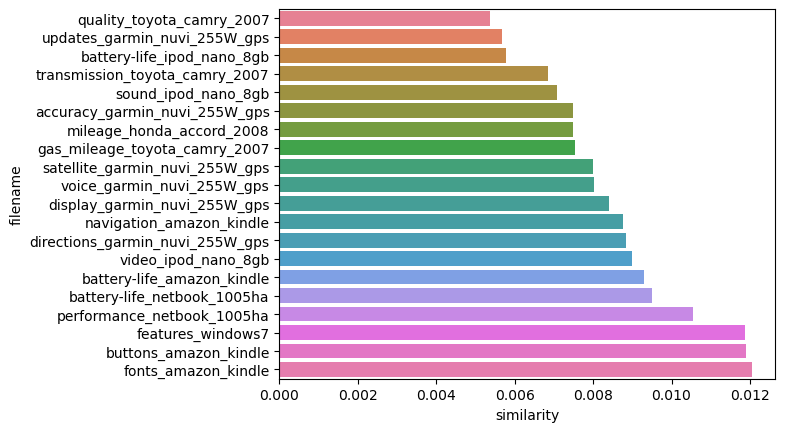

In [26]:
sns.barplot(x='similarity', y='filename', data=result_df.iloc[:20], hue='filename')
plt.show()

In [ ]:
hotel_idx = document_df[document_df['cluster'] == 1].index

# 기준이 될 문서를 0번째 문서로 지정 (추출된 호텔 관련 리뷰 중)
base_index = hotel_idx[0]
document_df.iloc[base_index]

# 호텔 관련 리뷰 중 유사도 높은 순으로 정렬
target_sim = cosine_similarity(opinions_vecs[base_index], opinions_vecs)
target_sim_sorted_idx = target_sim.argsort()[:, ::-1]
target_sim_sorted_idx = target_sim_sorted_idx[:, 1:]

hotel_sorted_idx = hotel_idx[target_sim_sorted_idx.reshape(-1)]

target_sim_val = np.sort(target_sim.reshape(-1)[::-1])
target_sim_val = target_sim_val[1:]

hotel_sim_df = document_df.iloc[hotel_sorted_idx]
hotel_sim_df['similarity'] = target_sim_val

sns.barplot(x='similarity', y='filename', data=hotel_sim_df, hue='filename')
plt.show()

IndexError: index 32 is out of bounds for axis 0 with size 15